# Cross Comparison

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from uncertainty_motion_prediction.dataloader import Dataloader
dataset=Dataloader();

pretrained_path="./pretrained/"

N_future = 10

In [2]:
from uncertainty_motion_prediction.predictor import ConstantVelocityPredictor

def get_cvm_pred(dataset_index, dt):
    return ConstantVelocityPredictor(N_future=N_future, dt=dt), DistanceErrorEvaluator(N_future=N_future)

In [3]:
from uncertainty_motion_prediction.predictor import ConstantVelocityKFPredictor

def get_kf_pred(dataset_index, dt):
    return  ConstantVelocityKFPredictor(N_future=N_future, dt=dt), DistanceErrorEvaluator(N_future=N_future)

In [4]:
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor.hmm_latent_segments import (
    segmentize_trajectory, normalise_segment, normalise_segment_batch
)

def get_hmm_pred(dataset_index, dt):

    clustering = KMeansOutcome.load_from_file(f"./pretrained/hmm_segment_clustering_all.pickle")
    state_dim = 60
    hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
    hmm.load_from_file(f"./pretrained/hmm_model_param_all.pickle")

    segment_length = 4
    num_segment = 5
    num_history_segment = 2
    num_future_segment = num_segment - num_history_segment
    history_traj_length = num_history_segment * (segment_length - 1) + 1
    return HMMLatentSegmentsPredictor(hmm, clustering, N_future_segment=num_future_segment),   DistanceErrorEvaluator(N_future=N_future, N_history=history_traj_length)
def get_hmm_test_traj(traj_dataset, dataset_index):
    segment_length = 4
    num_segment = 5
    num_history_segment = 2
    num_future_segment = num_segment - num_history_segment
    traj_length = num_segment * (segment_length - 1) + 1
    with open(f"./data/test_{dataset_index}.pickle", "rb") as _file:
        traj_dataset = pickle.load(_file)
    return traj_dataset.get_trajlets(
            length=traj_length * 0.4,
            overlap=1,
            to_numpy=True)
    

In [5]:
from fitter import Fitter, get_common_distributions, get_distributions

from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor import HMMContinuousEmissionsPredictor

from uncertainty_motion_prediction.predictor.hmm_continuous_emissions import normalise_segment_batch

def get_ghmm_pred(dataset_index, dt):
    model = None
    with open('./pretrained/gaussian_hmm_all.pkl', 'rb') as file:
        model = pickle.load(file)
    
    return HMMContinuousEmissionsPredictor(hmm = model, N_future_segment=3), DistanceErrorEvaluator(N_future=12)

def get_ghmm_test_traj(traj_dataset, dataset_index):
    segment_length = 4
    num_segment = 5# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

    with open(f"./data/test_{dataset_index}.pickle", "rb") as _file:
        traj_dataset = pickle.load(_file)
    return  traj_dataset.get_trajlets(
        length=segment_length * num_segment  * 0.4,
        overlap=3,
        to_numpy=True
        )

    

In [6]:
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator

algos =[
        ['cvm', get_cvm_pred,None],
        ['kf' , get_kf_pred,None],
        ['hmm' ,get_hmm_pred,get_hmm_test_traj],
        ['ghmm' ,get_ghmm_pred,get_ghmm_test_traj],
]

In [7]:
res = []

for i in range(len(dataset.get_key())):
    traj_dataset = dataset.load(i)
   
    res_algos ={}
    for pred in algos:
        if pred[2] is None:
            trajlets = traj_dataset.get_trajlets(length=16*0.4,  overlap=1, to_numpy=True)
            
        else:
            # for hmm and ghmm
            get_test_dataset = pred[2]
            trajlets = get_test_dataset(traj_dataset, i)
        
        dt = trajlets[0, 1, 4] - trajlets[0, 0, 4]
        
        predictor, evaluator = pred[1](i, dt =dt)
        
        evaluator.evaluate(predictor, trajlets)
        res_algos.update({pred[0]:evaluator.statistic()})
    res.append([dataset.get_key()[i], res_algos])
        

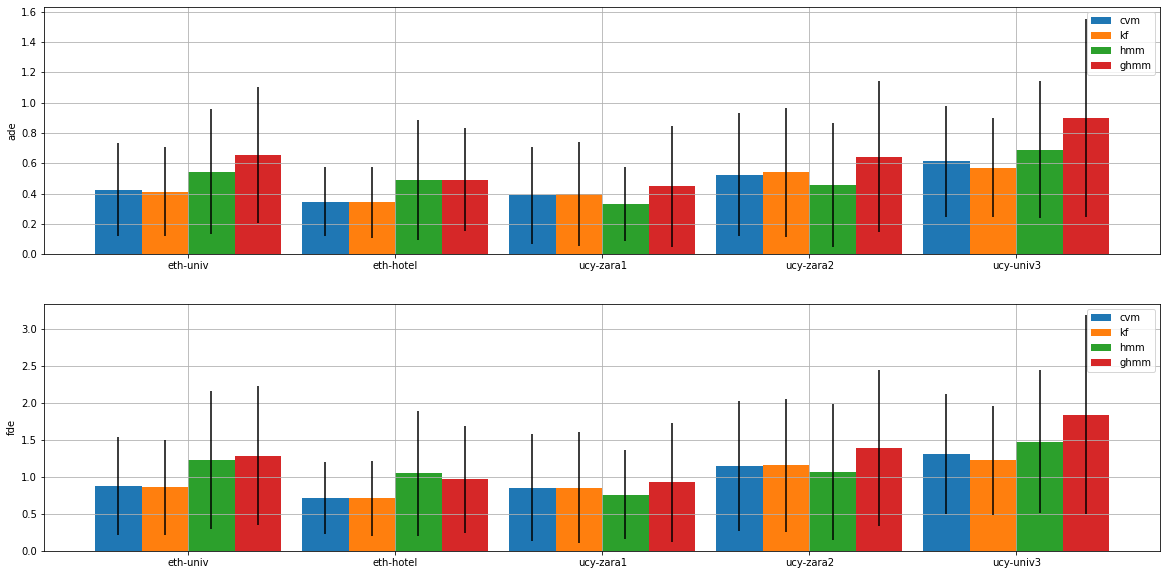

In [8]:
metrices  = evaluator.get_metrics()

fig, axs = plt.subplots(len(metrices),1, figsize=(20, 10))
labels = dataset.get_key()
x = np.arange(len(labels))

width = 0.3/len(algos) * 3

for m_index in range(len(metrices)):
    m  = metrices[m_index]
    axs[m_index].set_ylabel(m)
    name = []
    
    for algo_index in range(len(algos)):
        algo = algos[algo_index]
        value =[]
        std = []
        for i in res:
            value.append(i[1][algo[0]][m][0])
            std.append(i[1][algo[0]][m][1])
            
        axs[m_index].bar(x +  (width * (float(algo_index + 0.5)-float(len(algos))/2.0) ) , 
                         value, width, label=algo[0],yerr=std)
        
    axs[m_index].set_xticks(x)
    axs[m_index].set_xticklabels(labels)
    axs[m_index].legend()
    axs[m_index].grid()


        

# Conclusion
## Kalman filter
Kalman filter achieves better ADE/FDE results and lower standard deviation on 4 over 7 scenarios in comparison with constant velocity model.

However, the assumption on the Gaussian distribution of velocity not works well on long term predication and complex environment. 

First,  high divergence of paths can be observed from our evaluation results on sampling of possible future paths based on covariance matrix, it indicates that the uncertainty of the future paths can be large. 

Second, the intention of pedestrian can not be extracted by Kalman filter because its naturally linear dynamics property. Specifically, on ucy-zara1 and ucy-zara2 dataset, there exists a detour, and lacking consideration on such environment information makes it failed to make accurate estimation on whether a pedestrian want to turn around or not.
